Iteration 0, Gradient Magnitude: 9381552.095032623
Iteration 100, Gradient Magnitude: 219.264736705182
Iteration 200, Gradient Magnitude: 0.005163690386255084
Stopping based on gradient magnitude being close to 0.


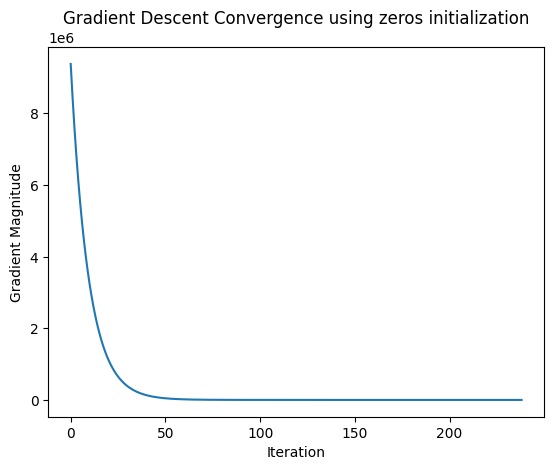

Initialization: zeros
Training MSE (Gradient Descent): 791206.4086939328
Test MSE (Gradient Descent): 344323.95116521895
Time taken: 2.3755409717559814 seconds
--------------------------------------------------
Iteration 0, Gradient Magnitude: 9233756.36167451
Iteration 100, Gradient Magnitude: 216.19459234897997
Iteration 200, Gradient Magnitude: 0.0050989851540441285
Stopping based on gradient magnitude being close to 0.


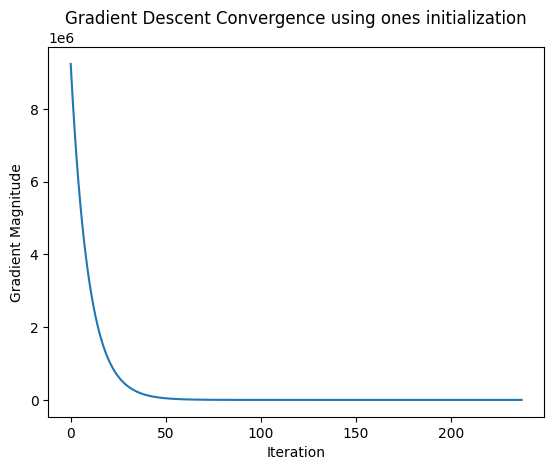

Initialization: ones
Training MSE (Gradient Descent): 791206.4086939328
Test MSE (Gradient Descent): 344323.95116521476
Time taken: 2.5557940006256104 seconds
--------------------------------------------------
Iteration 0, Gradient Magnitude: 9382523.505309258
Iteration 100, Gradient Magnitude: 219.2933391724287
Iteration 200, Gradient Magnitude: 0.005164493150754377
Stopping based on gradient magnitude being close to 0.


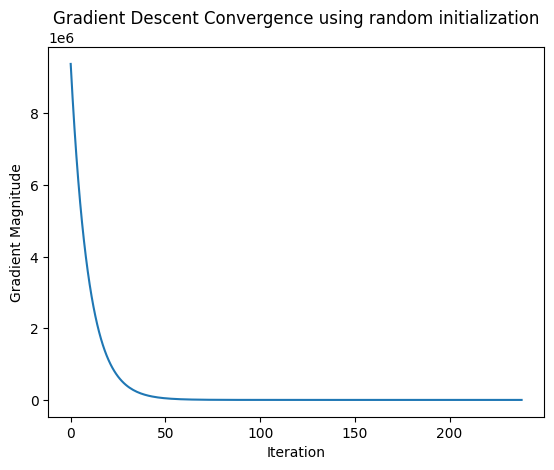

Initialization: random
Training MSE (Gradient Descent): 791206.4086939328
Test MSE (Gradient Descent): 344323.95116521895
Time taken: 2.2807388305664062 seconds
--------------------------------------------------
Iteration 0, Gradient Magnitude: 9381552.095032623
Initialization: zeros
Training MSE (Gradient Descent with Elastic Net): 791206.4086939334
Test MSE (Gradient Descent with Elastic Net): 344323.9510727787
Time taken: 0.07409787178039551 seconds
--------------------------------------------------
Iteration 0, Gradient Magnitude: 9233756.217434986
Initialization: ones
Training MSE (Gradient Descent with Elastic Net): 791206.4086939334
Test MSE (Gradient Descent with Elastic Net): 344323.9510727962
Time taken: 0.05297708511352539 seconds
--------------------------------------------------
Iteration 0, Gradient Magnitude: 9379927.006000655
Initialization: random
Training MSE (Gradient Descent with Elastic Net): 791206.4086939334
Test MSE (Gradient Descent with Elastic Net): 344323.95

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    test_indices = indices[:int(len(indices) * test_size)]
    train_indices = indices[int(len(indices) * test_size):]

    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

# Load the dataset
emissions_data = pd.read_csv('emissions_by_country.csv')

# Data preprocessing
for col in emissions_data.columns:
    if emissions_data[col].dtype in [np.float64, np.int64]:
        emissions_data[col].fillna(emissions_data[col].mean(), inplace=True)
    else:
        emissions_data[col].fillna(emissions_data[col].mode()[0], inplace=True)

features = ['Year', 'Temperature', 'GDP Per Capita (USD)']
X = emissions_data[features]
y = emissions_data['Total']

# Normalize data
X = (X - X.mean()) / X.std()
X['bias'] = 1

# Splitting data
X_train, X_test, y_train, y_test = custom_train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Descent Implementation 
def compute_gradient(X, y, w, lambda_val):
    prediction = X.dot(w)
    gradient = -2 * X.T.dot(y - prediction) + 2 * lambda_val * w
    return gradient

def gradient_descent_ridge(X, y, alpha=0.000001, lambda_val=1.0, num_iterations=1000, tol=1e-4, initialization="zeros"):
    if initialization == "zeros":
        w = np.zeros(X.shape[1])
    elif initialization == "ones":
        w = np.ones(X.shape[1])
    elif initialization == "random":
        w = np.random.randn(X.shape[1]) * 0.01
    
    prev_gradient_magnitude = float("inf")
    losses = []
    for iteration in range(num_iterations):
        gradient = compute_gradient(X, y, w, lambda_val)
        current_gradient_magnitude = np.linalg.norm(gradient)
        losses.append(current_gradient_magnitude)
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Gradient Magnitude: {current_gradient_magnitude}")
        
        if current_gradient_magnitude > prev_gradient_magnitude * 10 and iteration > 10:
            print("Early stopping due to gradient explosion.")
            break
        
        if current_gradient_magnitude < tol:
            print("Stopping based on gradient magnitude being close to 0.")
            break
        
        prev_gradient_magnitude = current_gradient_magnitude
        w = w - alpha * gradient
    
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Magnitude")
    plt.title(f"Gradient Descent Convergence using {initialization} initialization")
    plt.show()
    return w

initializations = ["zeros", "ones", "random"]
for init in initializations:
    start_time = time.time()
    w_gd = gradient_descent_ridge(X_train, y_train, alpha=0.000001, lambda_val=0.1, num_iterations=1000, initialization=init)
    y_pred_train_gd = X_train.dot(w_gd)
    y_pred_test_gd = X_test.dot(w_gd)
    mse_train_gd = np.mean((y_train - y_pred_train_gd) ** 2)
    mse_test_gd = np.mean((y_test - y_pred_test_gd) ** 2)
    end_time = time.time()
    print(f"Initialization: {init}")
    print(f"Training MSE (Gradient Descent): {mse_train_gd}")
    print(f"Test MSE (Gradient Descent): {mse_test_gd}")
    print(f"Time taken: {end_time - start_time} seconds")
    print("-" * 50)

# Saving weights from Ridge Regression
with open('ridge_gd_weights.pkl', 'wb') as file:
    pickle.dump(w_gd, file)

def compute_gradient_elastic_net(X, y, w, lambda_1, lambda_2):
    prediction = X.dot(w)
    gradient = -2 * X.T.dot(y - prediction)
    gradient += 2 * lambda_2 * w
    gradient += lambda_1 * np.sign(w)
    return gradient

def gradient_descent_elastic_net(X, y, alpha=0.0001, lambda_1=1.0, lambda_2=1.0, num_iterations=1000, tol=0.01, initialization="zeros"):
    if initialization == "zeros":
        w = np.zeros(X.shape[1])
    elif initialization == "ones":
        w = np.ones(X.shape[1])
    elif initialization == "random":
        w = np.random.randn(X.shape[1]) * 0.01
    
    prev_gradient_magnitude = float("inf")
    for iteration in range(num_iterations):
        gradient = compute_gradient_elastic_net(X, y, w, lambda_1, lambda_2)
        current_gradient_magnitude = np.linalg.norm(gradient)
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Gradient Magnitude: {current_gradient_magnitude}")
        
        if current_gradient_magnitude > prev_gradient_magnitude * 10:
            print("Early stopping due to gradient explosion.")
            break
        
        if np.all(np.abs(gradient) < tol):
            break
        
        prev_gradient_magnitude = current_gradient_magnitude
        w = w - alpha * gradient
    return w

initializations = ["zeros", "ones", "random"]
for init in initializations:
    start_time = time.time()
    w_gd_en = gradient_descent_elastic_net(X_train, y_train, alpha=0.00001, lambda_1=0.1, lambda_2=0.1, num_iterations=1000, initialization=init)
    y_pred_train_gd_en = X_train.dot(w_gd_en)
    y_pred_test_gd_en = X_test.dot(w_gd_en)
    mse_train_gd_en = np.mean((y_train - y_pred_train_gd_en) ** 2)
    mse_test_gd_en = np.mean((y_test - y_pred_test_gd_en) ** 2)
    end_time = time.time()
    print(f"Initialization: {init}")
    print(f"Training MSE (Gradient Descent with Elastic Net): {mse_train_gd_en}")
    print(f"Test MSE (Gradient Descent with Elastic Net): {mse_test_gd_en}")
    print(f"Time taken: {end_time - start_time} seconds")
    print("-" * 50)

# Saving weights from Elastic Net Regularization
with open('elastic_net_gd_weights.pkl', 'wb') as file:
    pickle.dump(w_gd_en, file)

print("Model weights saved successfully!")
